# SVB evaluation

This is a preliminary evaluation of hyrbid SVB and comparison with volumetric BASIL. 

A single cortical hemisphere at 32k mesh resolution (HCP functional standard) is used to define anatomy. A sinusoidal variation of CBF is simulated on the cortical surface, whereas all other parameters (WM CBF, GM ATT, WM ATT) are assigned constant default values across the brain. No subcortical GM structures are considered. 

Multi-time ASL data is simulated with increasing levels of noise, and then the following analysis pipelines run: 
1. Hybrid SVB, inferring both CBF and ATT, using spatial priors on both parameters. All GM parameters are estimated on the surface, and WM in the volume.  
2. BASIL volumetric PVEc (via oxford_asl), inferring both CBF and ATT, with a spatial prior on CBF only, followed by volume -> surface projection with Toblerone to transform GM parameters. 


High level summary of results: 
1. Hybrid SVB seems to work (at last)
2. For cortical CBF, there is a clear divergence with BASIL at very high noise levels: BASIL smooths over all detail to return a normal distribution, whereas SVB actually returns increasingly wide distributions to preserve spatial detail (the bright spots are even brighter, and vice-versa)
3. Qualitatively, I think an argument can be made that SVB has some advantages over BASIL at high noise. What metric could we use to show this quantitatively?
4. How much noise is too much? Are the values used below realistic or are they too pathlogically difficult to be realistic?
5. The spatial prior on ATT in SVB isn't as constraining as the normal prior in BASIL. When I use a normal prior in SVB, that seems to perform even worse than the spatial one. Thinking out loud, could we implement the combined spatial and non-spatial prior in SVB? If we are willing to approximate the two priors as statistically independent, then we could just calculate the log(cost) over each prior and sum them together for the objective function?
6. It is difficult to be sure convergence has been reached in SVB under a fixed number of epochs. 


In [17]:
%load_ext autoreload 
%autoreload 2 

import sys 

sys.path.insert(1, '/Users/thomaskirk/modules/svb_module')
sys.path.insert(1, '/Users/thomaskirk/modules/svb_models_asl')
import svb_asl
from svb.data import DataModel
from svb_models_asl import AslRestModel 

import numpy as np
import toblerone as tob 
import copy 
import subprocess

import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)
import seaborn as sns 
import pyvista as pv 
import pandas as pd 
import nibabel as nib 
from scipy import stats
import regtricks as rt 
import glob
from multiprocessing import Pool
import fabber_funcs
import os.path as op
import helpers 


niiload = lambda p: np.squeeze(nib.load(p).get_fdata().flatten())
giiload = lambda p: np.squeeze(nib.load(p).darrays[0].data)

ANATOMY = 'brain'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load up a pre-computed projector for the single hemisphere. The voxel grid is 3mm isotropic. 

In [18]:
fastdir = "/Users/thomaskirk/Data/singlePLDpcASL/T1.anat"
fsdir = "/Users/thomaskirk/Data/singlePLDpcASL/fs/surf"

LWS = op.join(fsdir, 'lh_white_32.surf.gii')
LPS = op.join(fsdir, 'lh_pial_32.surf.gii')
sph = tob.Surface('sph_32k.surf.gii')

firstdir = "/Users/thomaskirk/Data/singlePLDpcASL/T1.anat/first_results"
ref = "/Users/thomaskirk/Data/singlePLDpcASL/T1.anat/T1.nii.gz"
subcorts = glob.glob(op.join(firstdir, '*-L_*.vtk'))
t1_spc = rt.ImageSpace(ref)
base_spc = t1_spc.resize_voxels(1 / t1_spc.vox_size)
base_spc

ImageSpace with properties:
size:          [ 181.000  200.000  169.000], 
voxel size:    [   1.000    1.000    1.000], 
field of view: [ 181.000  200.000  169.000],
vox2world:     [  -1.000    0.000    0.000   93.328]
               [   0.000    1.000    0.000  -84.324]
               [   0.000    0.000    1.000  -81.239]
               [   0.000    0.000    0.000    1.000]
loaded from:   <ImageSpace not created from file path>

In [19]:
rois = {}
for path in subcorts: 
    name = op.splitext(op.split(path)[1])[0]
    s = tob.Surface(path, name)
    s = s.transform(t1_spc.FSL2world)
    rois[name] = s 

hemi = tob.Hemisphere(LWS, LPS, side='L')

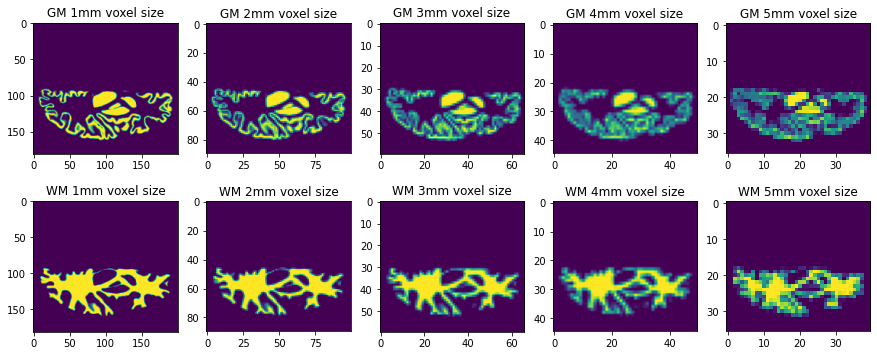

In [20]:
vox_sizes = np.array([1,2,3,4,5])

projectors = {}
fig, axes_all = plt.subplots(2, len(vox_sizes), figsize=(3*len(vox_sizes),6))
for row in range(2): 
    for v,ax in zip(vox_sizes, axes_all[row,:]): 
        spc = base_spc.resize_voxels(v)
        proj_path = f'{ANATOMY}_proj_{v}.h5'
        if not op.exists(proj_path): 
            p = tob.Projector(hemi, spc, rois=rois)
            p.save(proj_path)
        p = tob.Projector.load(proj_path)
        projectors[v] = p 
        ax.imshow(p.pvs()[:,:,p.spc.size[-1]//2,row])
        ax.set_title('{} {}mm voxel size'.format(['GM','WM'][row], v))

vox_sizes = vox_sizes[1:]

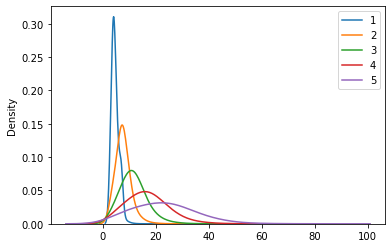

In [21]:
fig, ax = plt.subplots() 
for v, p in projectors.items(): 
    v2s = (p.vol2surf_matrix(False) > 0)
    vertex_count = v2s.sum(0).A.flatten()
    sns.kdeplot(vertex_count[vertex_count > 0], label=v, ax=ax, bw=0.5)

ax.legend()

Simulate sinusoidal CBF map on the cortical *inflated* surface (this gives a smoother and less convoluted map). 

In [22]:
ctx_cbf = helpers.make_activation(sph)
helpers.pv_plot(sph, ctx_cbf, clim=[40, 80]) 

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

ASL parameters: multi-PLD pCASL 

In [23]:
TIME_SCALE = 1e1
PLDS = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5]) * TIME_SCALE
BOLUS = 1.8
ATT = np.array([1.3, 1.6]) * 1e1 
RPT = 8 
BASIL_OPTS = { 'bolus': BOLUS, 'bat': 1.3, 'batwm': 1.6, 'plds': PLDS / TIME_SCALE , 'ibf': 'tis' }
nverts = sph.n_points

Function to simulate data using SVB's *aslrest* model. NB: data is simulated from hybrid space parameters (ie, a set of surface ground truth values, volumetric ground truth), and then projected down into a volumetric representation. This is fundamentally different to simulating data starting from volumetic parameter values. 

In [24]:
data_base = helpers.simulate_data(projectors[3], 0, RPT, ctx_cbf)

Reshaping data as 4D volume


In [25]:
proj_base = projectors[1]
pvs_base = proj_base.pvs()
mask_base = (pvs_base[...,:2] > 0.1).any(-1)
data_base, data_model_base = helpers.simulate_data(proj_base, 0, RPT, ctx_cbf)
data_base.shape

Reshaping data as 4D volume


(181, 200, 169, 48)

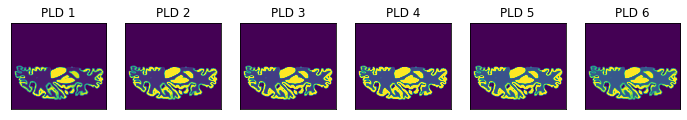

In [26]:
fig, axes = plt.subplots(1,6, figsize=(12,2))
for pld, ax in enumerate(axes): 
    start = (pld * RPT) 
    end = start + RPT 
    ax.imshow(data_base[:,:,proj_base.spc.size[-1]//2,start:end].mean(-1), vmin=0, vmax=40)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'PLD {pld+1}')

In [27]:
gm_mask = pvs_base[...,0] > 0.8
pld_signals = []
for pld in range(6): 
    start = (pld * RPT)  
    end = start + RPT 
    data_pld = data_base[gm_mask,start:end]
    sig = data_pld.mean(-1)
    pld_signals.append( sig.mean() )

mu = max(pld_signals)
mu 

56.85461

In [28]:
SNR_RATIO = [-1, -0.5, 0, 0.5, 1]
get_snr = lambda vox_vol: 1.97 * ((vox_vol / 58.49) ** 0.5)

In [29]:
input_data = {} 
for snr_ratio in SNR_RATIO:
    input_data[snr_ratio] = {} 
    snr_eff = get_snr(1 ** 3) * (2 ** snr_ratio) 
    noise_base = mu / snr_eff 
    np.random.seed(1)
    d = data_base + np.random.normal(0, noise_base, size=data_base.shape)

    for v in vox_sizes: 
        spc_v = projectors[v].spc 
        data_v = rt.Registration.identity().apply_to_array(d, src=proj_base.spc, ref=spc_v, order=1)
        input_data[snr_ratio][v] = data_v

1.9777311903815544

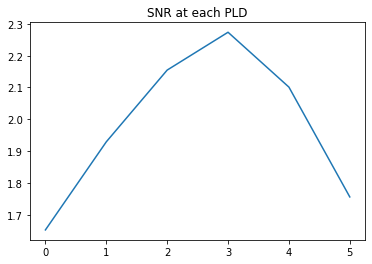

In [30]:
v = 4
snr = 0 
gm_mask = (projectors[v].pvs()[...,0] > 0.8)
sig_all_pld = input_data[0][v][gm_mask,:].mean(-1)

y = []
for pld in range(6): 
    start = (pld * RPT) 
    end = start + RPT  
    data_pld = input_data[0][v][gm_mask,start:end]
    sig = data_pld.mean(-1)
    noise = data_pld.std(-1)
    y.append( (sig / noise).mean() )

plt.plot(y)
plt.title("SNR at each PLD")
np.mean(y)

Text(0.5, 1.0, 'SNR at each voxel size')

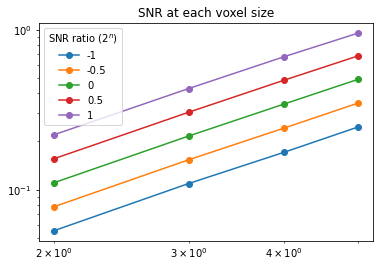

In [31]:
snrs = [] 
for snr_ratio in SNR_RATIO: 
    s = [] 
    for v in vox_sizes: 
        mask = (projectors[v].pvs()[...,1] > 0.8)
        d = input_data[snr_ratio][v][mask,:]
        sig = d.mean(-1)
        noise = d.std(-1)
        s.append( (sig / noise).mean() )
    snrs.append(s)

snrs = np.array(snrs)
fig, ax = plt.subplots()
ax.plot(vox_sizes, snrs.T, marker='o')
ax.legend(SNR_RATIO, title=r'SNR ratio (2$^n$)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("SNR at each voxel size")

The experiment: simulate data with increasing noise, and run both SVB and BASIL on them. There are 4 ASL repeats per PLD, which makes (4 * 6) volumes in total. 

In [34]:
oxasl_jobs = [] 

for v in vox_sizes: 
    proj = projectors[v]
    mask = (proj.pvs()[...,:2] > 0.1).any(-1)
    pvs = proj.pvs()

    # Run with a fixed low level of noise and varying numbers of repeats 
    for snr in SNR_RATIO:
        # BASIL infer att 
        data = input_data[snr][v]
        odir = f"{ANATOMY}_test/basil_vox-{v}_snr-{snr}_rpt-{RPT}"
        if not op.exists(op.join(odir, 'output')):
            oxasl_jobs.append( (data, mask.astype(np.int8), odir, BASIL_OPTS, pvs[...,:2], proj) )

with Pool() as pool: 
    pool.starmap(fabber_funcs.oxasl_cmd, oxasl_jobs)

for v in vox_sizes: 
    proj = projectors[v]
    mask = (proj.pvs()[...,:2] > 0.05).any(-1)
    pvs = proj.pvs()

    for snr in SNR_RATIO:                    

        data = input_data[snr][v]
        data_mean = np.stack([ data[...,(idx*RPT):(idx+1)*RPT].mean(-1) for idx in range(len(PLDS)) ], axis=-1)
        odir = f"{ANATOMY}_test/svb_vox-{v}_snr-{snr}_rpt-{RPT}"
        if not op.exists(op.join(odir, 'step2/mean_ftiss_L_cortex.func.gii')):
            svb_asl.main(proj.spc.make_nifti(data_mean), PLDS, proj, odir)

INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model version 0.0.1.post40
INFO :  - Bolus duration: 18.0
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: tf.Tensor([20.5 23.  25.5 28.  30.5 33. ], shape=(6,), dtype=float32)
INFO :  - Post-labelling delays (for CASL instead of TIs): tf.Tensor([ 2.5  5.   7.5 10.  12.5 15. ], shape=(6,), dtype=float32)
INFO :  - Number of repeats - single value or one per TI/PLD: 1
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: 13.0
INFO :  - Bolus arrival time: tf.Tensor([12.8101635 12.966997  13.260787  ... 11.953529  12.009937  11.760006 ], shape=(49071,), dtype=float32)
INFO :  - Bolus arrival time prior std.dev.: 3.0
INFO :  - Perfusion value to use in estimation of effective T1: 0.01
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: 0.9
INFO :  - Include WM parameters: False
INFO :  - WM 